In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as mno
sns.set_style("darkgrid", {"grid.color": ".2", "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#reading data
df = pd.read_csv('../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

### Rudimentary inspection of dataset.

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.shape

(200, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
#statistical summary of all the numerical variables in dataset
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [8]:
#columns names
df.columns = ['CustomerID', 'Gender', 'Age', 'Annual Income', 'Spending Score']

In [9]:
#checking missing values
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

,Total,Percent
CustomerID,0,0.0
Gender,0,0.0
Age,0,0.0
Annual Income,0,0.0
Spending Score,0,0.0




> Dataset has no missing values and all the features have appropriate data types.



## Exploratory Data Analysis

In [10]:
#Gender
df.Gender.value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

In [11]:
#company's campaingn ids' composition
ge = df['Gender'].value_counts()
ge_df = pd.DataFrame({'labels': ge.index,'values': ge.values})
px.pie(ge_df, names ='labels', values='values', title='Gender Composition', hole = 0.35)

<Figure size 1296x1152 with 0 Axes>

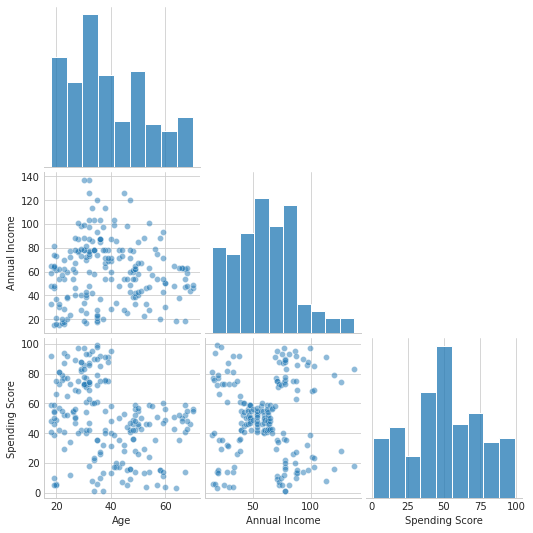

In [12]:
#Distribution of numerical variables
num_cols = [col for col in df.select_dtypes(include = np.number).columns if col != 'CustomerID']
plt.figure(figsize = [18, 16])
with plt.style.context('seaborn-whitegrid'):
    sns.pairplot(df[num_cols], corner = True, plot_kws = {'alpha': 0.5})



> We can already see the existance of clusters in the data.



<Figure size 1296x1152 with 0 Axes>

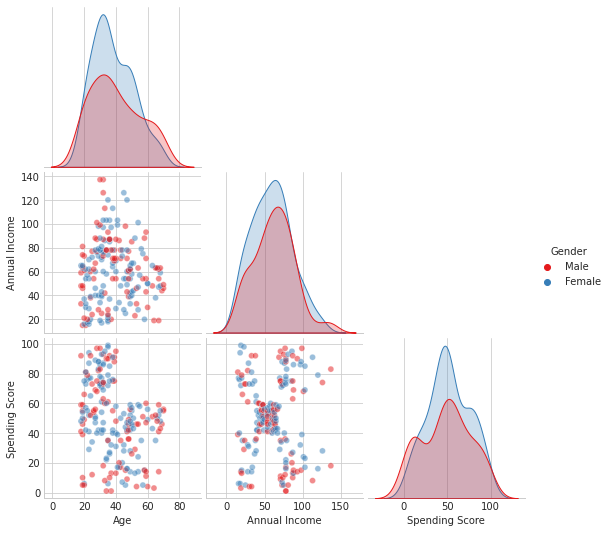

In [13]:
#Distribution of numerical variables wrt gender
cols = [col for col in df.columns if col != 'CustomerID']
plt.figure(figsize = [18, 16])
with plt.style.context('seaborn-whitegrid'):
    sns.pairplot(df[cols], hue = 'Gender' ,corner = True, plot_kws = {'alpha': 0.5}, palette = 'Set1')

In [14]:
len(num_cols)

3

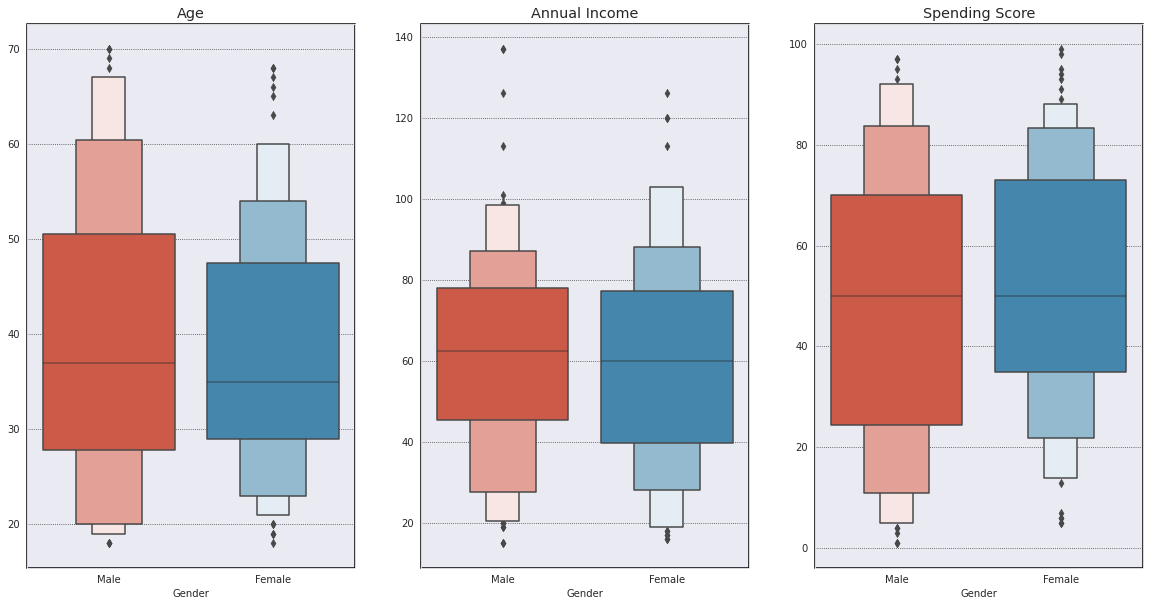

In [15]:
plt.figure(figsize = [20, 10])
for i in range(len(num_cols)):
    plt.subplot(1,len(num_cols), i + 1)
    with plt.style.context('ggplot'):
        ax = sns.boxenplot(data = df, y = num_cols[i], x = 'Gender')
        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth(1.5)
        ax.set_ylabel('')
        ax.set_title('{}'.format(num_cols[i]))



> We do not have any extreme outliers. All the data points are in acceptable range.



In [16]:
L = [0, 0.2, 0., 0.75, 0.95, 1]
df['Annual Income'].quantile(L)

0.00     15.0
0.20     37.8
0.00     15.0
0.75     78.0
0.95    103.0
1.00    137.0
Name: Annual Income, dtype: float64

In [17]:
#binning age and income into groups
df['age_group'] = pd.cut(df.Age, [0,25,35,45,55,65,200], 
                            labels = ['<25','25-35','35-45','45-55','55-65','>65'])
df['income_group'] = pd.cut(df['Annual Income'], [0,30,50,75,100,200], 
                            labels = ['low','low-medium','medium','high-medium','high'])
df.head()

,CustomerID,Gender,Age,Annual Income,Spending Score,age_group,income_group
0,1,Male,19,15,39,<25,low
1,2,Male,21,15,81,<25,low
2,3,Female,20,16,6,<25,low
3,4,Female,23,16,77,<25,low
4,5,Female,31,17,40,25-35,low


In [18]:
gag = df.groupby(['Gender', 'age_group']).CustomerID.count()
gag = gag.reset_index()

fig = px.bar(gag, x='age_group', y='CustomerID', color='Gender',
             labels={'age_group':'Age Group', 'CustomerID':'Count'}, title = 'Composition of Age-groups', 
             category_orders = {'age_group': ['<25','25-35','35-45','45-55','55-65','>65']}, width = 1000)
fig.show()

In [19]:
#Aveerage spending score of age-groups
gag = df.groupby(['Gender', 'age_group'])['Spending Score'].mean()
gag = gag.reset_index()
fig = px.bar(gag, x='age_group', y='Spending Score', color='Gender', barmode = 'group',
             labels={'age_group':'Age Group', 'Spending Score':'Average'}, title = 'Average Spending Score', 
             category_orders = {'age_group': ['<25','25-35','35-45','45-55','55-65','>65']}, color_discrete_sequence = ['darkcyan', 'darkseagreen'], width = 1200)
fig.show()



> Interestingly, even though there are less customers in age group '>65', the spending score of the group is very descent.



In [20]:
iag = df.groupby(['Gender', 'income_group']).CustomerID.count()
iag = iag.reset_index()

fig = px.bar(iag, x='income_group', y='CustomerID', color='Gender',
             labels={'income_group':'Income Group', 'CustomerID':'Count'}, title = 'Composition of Age-groups', 
             category_orders = {'age_group': ['low','low-medium','medium','high-medium','high']}, width = 1000)
fig.show()

In [21]:
#Aveerage spending score of income-groups
iag = df.groupby(['Gender', 'income_group'])['Spending Score'].mean()
iag = iag.reset_index()
fig = px.bar(iag, x='income_group', y='Spending Score', color='Gender', barmode = 'group',
             labels={'income_group':'Income Group', 'Spending Score':'Average'}, title = 'Average Spending Score',
             category_orders = {'age_group': ['low','low-medium','medium','high-medium','high']}, color_discrete_sequence = ['darkcyan', 'darkseagreen'], width = 1200)
fig.show()



> Average spending score is almost same accross all income groups.



## Clustering

### Preprocessing

In [22]:
#numerical columns
cols = [col for col in df.select_dtypes(include = np.number).columns if col != 'CustomerID']
cols

['Age', 'Annual Income', 'Spending Score']

In [23]:
df_num = df[cols]
df_num.head()

,Age,Annual Income,Spending Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [24]:
#rescaling
scaler = StandardScaler()
df_num = scaler.fit_transform(df_num)

df_num = pd.DataFrame(df_num)
df_num.columns = cols

In [25]:
#giving addition wweights to variables, Annual Income and Spending Score as there were natural clusters in data with these variables
#these variables appear to be more important than age for the given problem
#weights, 2:2:1
df_num['Annual Income'] = df_num['Annual Income']*2
df_num['Spending Score'] = df_num['Spending Score']*2
df_num.head()

,Age,Annual Income,Spending Score
0,-1.424569,-3.477998,-0.869603
1,-1.281035,-3.477998,2.391408
2,-1.352802,-3.401660,-3.431826
3,-1.137502,-3.401660,2.080836
4,-0.563369,-3.325321,-0.791960


In [26]:
df_num.agg([np.mean, np.std]).round(2)

,Age,Annual Income,Spending Score
mean,-0.0,-0.00,-0.00
std,1.0,2.01,2.01


### Clustering Tendency of data

The Hopkins statistic is used to assess the clustering tendency of a data set by measuring the probability that a given data set is generated by a uniform data distribution. In other words, it tests the spatial randomness of the data.

A value for H higher than 0.75 indicates a clustering tendency at the 90% confidence level.

The null and the alternative hypotheses are defined as follow:

> Null hypothesis: the data set D is uniformly distributed (i.e., no meaningful clusters)

> Alternative hypothesis: the data set D is not uniformly distributed (i.e., contains meaningful clusters)

We can conduct the Hopkins Statistic test iteratively, using 0.5 as the threshold to reject the alternative hypothesis. That is, if H < 0.5, then it is unlikely that D has statistically significant clusters.

Put in other words, If the value of Hopkins statistic is close to 1, then we can reject the null hypothesis and conclude that the dataset D is significantly a clusterable data.

In [27]:
#Function for Hopkin's statistic 
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hhopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [28]:
##Other method to compute hopkin's statistic
#from pyclustertend import hopkins ## the hopkins test
#1 - hopkins(df_num[['Annual Income', 'Spending Score']].values, df_num[['Annual Income', 'Spending Score']].shape[0])

In [29]:
hhopkins(df_num)

0.7013860401327259



> This indicates that data indeed has clustering tendency.


## K-Means

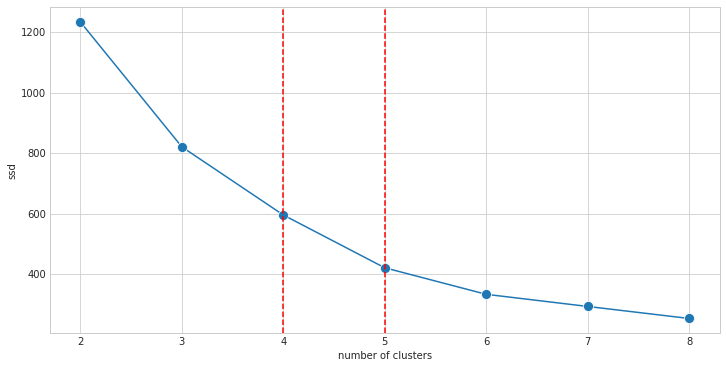

In [30]:
# elbow-curve
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_num)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize = [12, 6])
    sns.lineplot(np.arange(2,9,1), ssd, marker='o', markersize = 10)
    plt.xlabel('number of clusters')
    plt.axvline(4, ls="--", c="red")
    plt.axvline(5, ls="--", c="red")
    plt.ylabel('ssd')

In [31]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
sil = []
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_num)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_num, cluster_labels)
    sil.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.2941333057646131
For n_clusters=3, the silhouette score is 0.39018412820765447
For n_clusters=4, the silhouette score is 0.4143219922749774
For n_clusters=5, the silhouette score is 0.4545692046079985
For n_clusters=6, the silhouette score is 0.4500942591120322
For n_clusters=7, the silhouette score is 0.4387119539130137
For n_clusters=8, the silhouette score is 0.42584961459226306


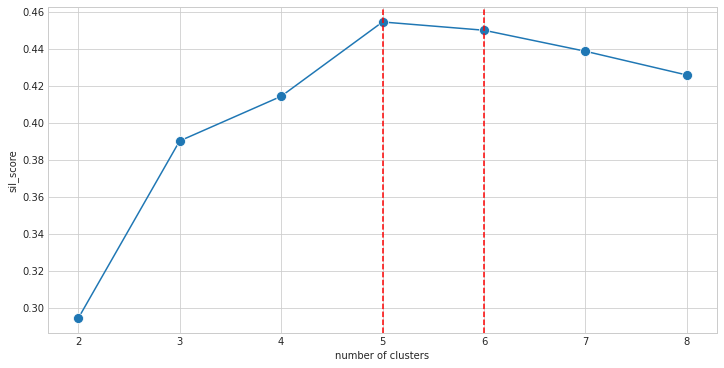

In [32]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize = [12, 6])
    sns.lineplot(np.arange(2,9,1), sil, marker='o', markersize = 10)
    plt.xlabel('number of clusters')
    plt.axvline(5, ls="--", c="red")
    plt.axvline(6, ls="--", c="red")
    plt.ylabel('sil_score')

Considering both elbow curve and silhoutte analysis, let's choose k = 5 and see if the clusters make sense.

In [33]:
#model with k=5
num_cols = ['Age', 'Annual Income', 'Spending Score']
kmeans = KMeans(n_clusters = 5, init='k-means++', max_iter = 500)
kmeans.fit(df_num[num_cols])

KMeans(max_iter=500, n_clusters=5)

In [34]:
kmeans.labels_

array([2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 3,
       2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=int32)

In [35]:
df_clusters = df[num_cols].copy()

In [36]:
#assign the label
df_clusters['kmeans_id'] = kmeans.labels_
df_num['kmeans_id'] = kmeans.labels_

df_clusters.head()

,Age,Annual Income,Spending Score,kmeans_id
0,19,15,39,2
1,21,15,81,4
2,20,16,6,2
3,23,16,77,4
4,31,17,40,2


### Interpreting the Clusters

In [37]:
def box_plot(x, y):
    ax = sns.boxplot(x = x, y = y, data = df_clusters)
    ax.set_ylabel(y, fontsize = 14)
    ax.set_xlabel('Cluster ID', fontsize = 14)
    ax.set_title('{} distribution of clusters'.format(y), fontsize = 16, fontweight = 'bold')
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(1.5)
    plt.show()

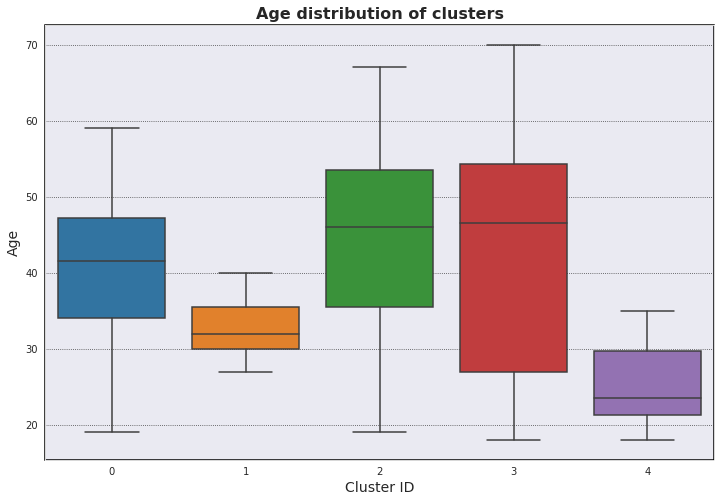

In [38]:
#Age
plt.figure(figsize = [12,8])
box_plot('kmeans_id', 'Age')

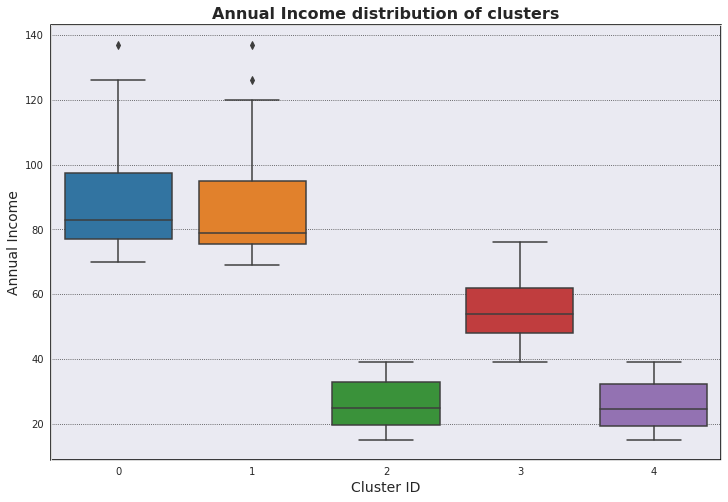

In [39]:
#Annual Income
plt.figure(figsize = [12,8])
box_plot('kmeans_id', 'Annual Income')

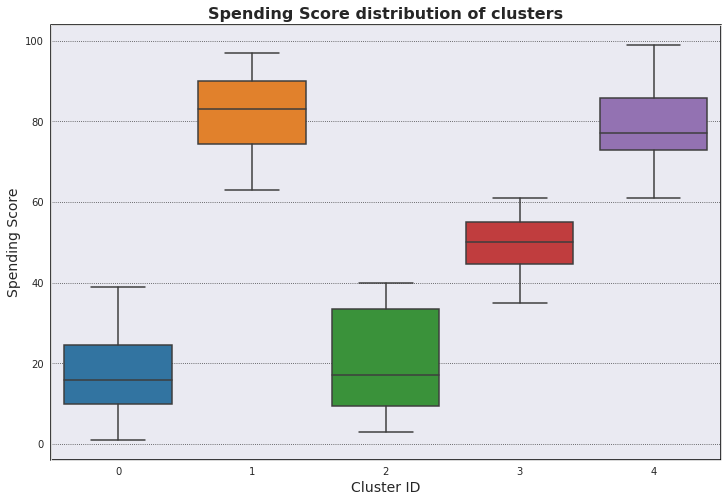

In [40]:
#Spending score
plt.figure(figsize = [12,8])
box_plot('kmeans_id', 'Spending Score')

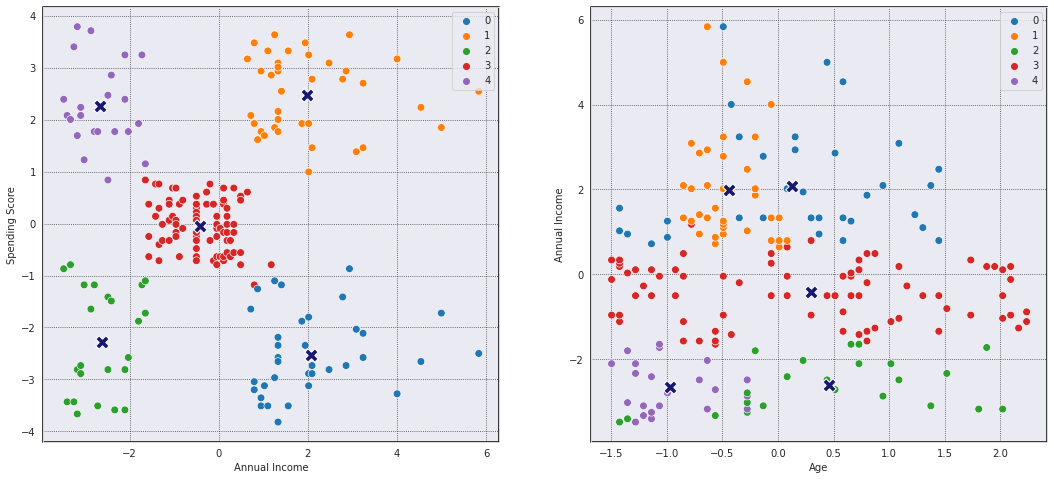

In [41]:
plt.figure(figsize = [18, 8])

plt.subplot(121)
ax1 = sns.scatterplot(data = df_num, x = 'Annual Income', y = 'Spending Score', hue = 'kmeans_id', palette = 'tab10', s = 60)
sns.scatterplot(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], ax = ax1, color = 'midnightblue', marker = 'X', s = 180)
ax1.patch.set_edgecolor('black')
ax1.patch.set_linewidth(1.5)

plt.subplot(122)
ax2 = sns.scatterplot(data = df_num, x = 'Age', y = 'Annual Income', hue = 'kmeans_id', palette = 'tab10', s = 60)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], ax = ax2, color = 'midnightblue', marker = 'X', s = 180)
ax2.patch.set_edgecolor('black')
ax2.patch.set_linewidth(1.5)



> The clusters look very distinct. The clusters obtained do make sense. The five clusters being,
1. clients with high annual income and high spending score
2. clients with high annual income and low spending score
3. clients with low annual income and low spending score
4. clients with medium annual income and medium spending score
5. clients with high annual income and high spending score 

Cluster are not very distinct wrt age variable.

In [42]:
df_clusters['kmeans_id'] = df_clusters['kmeans_id'].astype('str')

In [43]:
#visualizing all three variables
fig = px.scatter_3d(df_clusters, x = 'Age', y = 'Annual Income', z = 'Spending Score',
              color='kmeans_id', color_continuous_scale = 'hsv', category_orders = {'kmeans_id': ['0', '1', '2', '3', '4']})
fig.update_layout(legend=dict(orientation="h"))
fig.show()

## Hierarchical Clustering

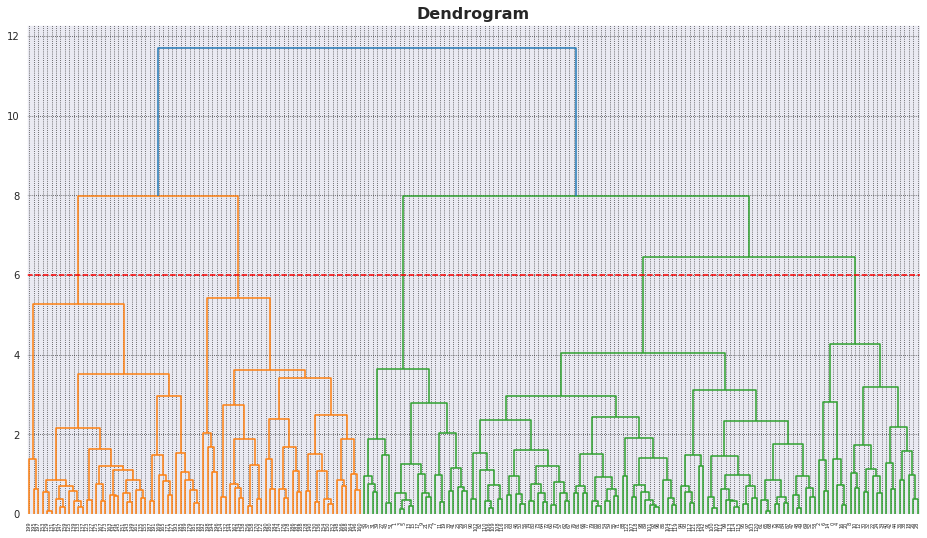

In [44]:
#using complete linkage
plt.figure(figsize = (16, 9))

Z = linkage(df_num, method="complete", metric='euclidean')
dendrogram(Z)
plt.axhline(6, ls="--", c = "r")
plt.title('Dendrogram', fontsize = 16, fontweight = 'bold')
plt.show()



> If we cut the dendrogram at y = 6, then we will get 5 clusters.



In [45]:
#5 clusters
hc_labels = cut_tree(Z, height = 6).reshape(-1, )
hc_labels

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 3, 2, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 2, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3])

In [46]:
#assign the label
df_clusters['hc_id'] = hc_labels
df_num['hc_id'] = hc_labels

df_clusters.head()

,Age,Annual Income,Spending Score,kmeans_id,hc_id
0,19,15,39,2,0
1,21,15,81,4,1
2,20,16,6,2,0
3,23,16,77,4,1
4,31,17,40,2,0


### Interpreting the Clusters

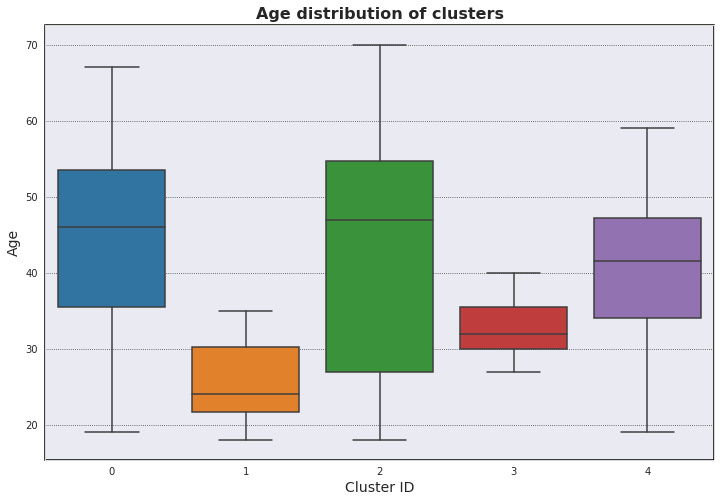

In [47]:
#Age
plt.figure(figsize = [12,8])
box_plot('hc_id', 'Age')

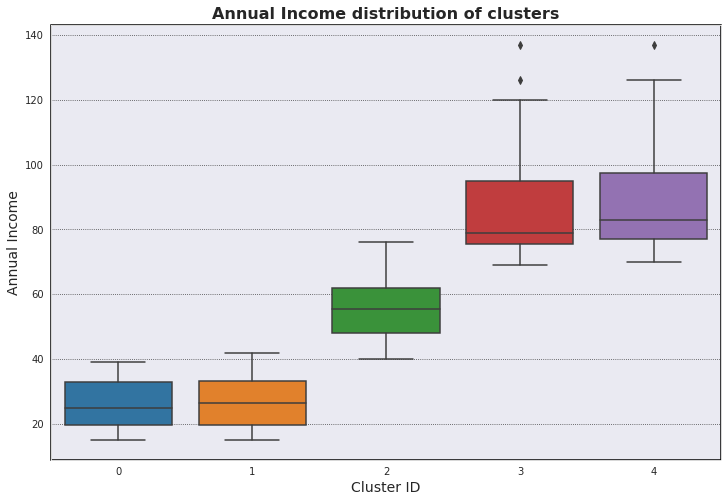

In [48]:
#Annual Income
plt.figure(figsize = [12,8])
box_plot('hc_id', 'Annual Income')

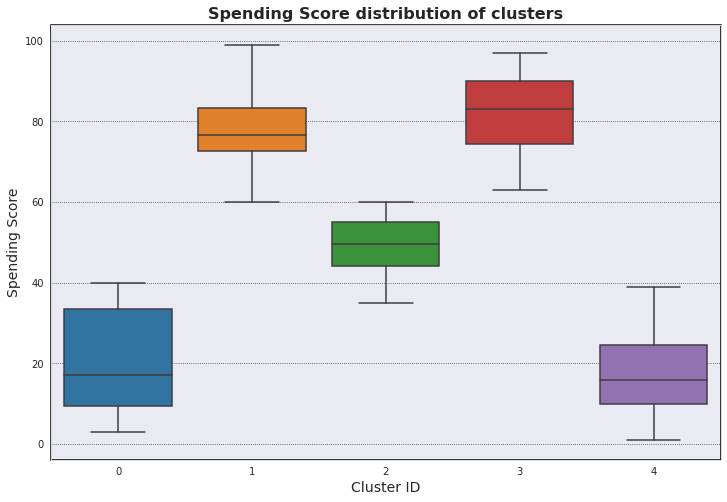

In [49]:
#Spending Score
plt.figure(figsize = [12,8])
box_plot('hc_id', 'Spending Score')

In [50]:
#centrod of HC clusters
hc_centroids = [df_num.loc[df_num.hc_id == i, num_cols].mean().values for i in range(5)]
hc_centroids = np.array(hc_centroids)
hc_centroids

array([[ 0.4569666 , -2.61503738, -2.27393072],
       [-0.93416308, -2.56511287,  2.14230313],
       [ 0.31347322, -0.38921073, -0.05932731],
       [-0.44191719,  1.9831661 ,  2.47900551],
       [ 0.13037615,  2.07565356, -2.53245981]])

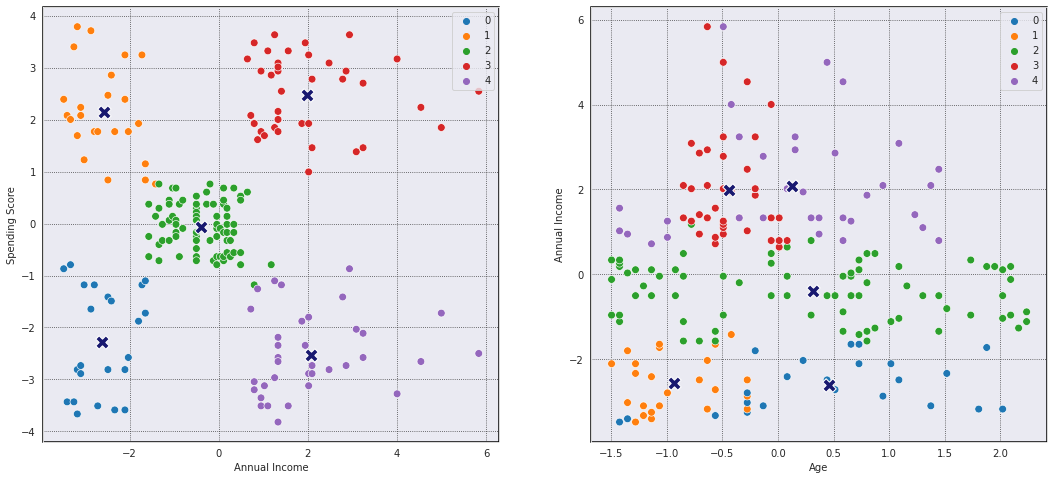

In [51]:
plt.figure(figsize = [18, 8])

plt.subplot(121)
ax1 = sns.scatterplot(data = df_num, x = 'Annual Income', y = 'Spending Score', hue = 'hc_id', palette = 'tab10', s = 60)
sns.scatterplot(hc_centroids[:,1], hc_centroids[:,2], ax = ax1, color = 'midnightblue', marker = 'X', s = 180)
ax1.patch.set_edgecolor('black')
ax1.patch.set_linewidth(1.5)

plt.subplot(122)
ax2 = sns.scatterplot(data = df_num, x = 'Age', y = 'Annual Income', hue = 'hc_id', palette = 'tab10', s = 60)
sns.scatterplot(hc_centroids[:,0], hc_centroids[:,1], ax = ax2, color = 'midnightblue', marker = 'X', s = 180)
ax2.patch.set_edgecolor('black')
ax2.patch.set_linewidth(1.5)



> We have obtained almost simillar clusters with agglomerative Hierarchical Clustering.



In [52]:
df_clusters['hc_id'] = df_clusters['hc_id'].astype('str')

In [53]:
#visualizing all three variables
fig = px.scatter_3d(df_clusters, x = 'Age', y = 'Annual Income', z = 'Spending Score',
              color='hc_id', color_continuous_scale = 'hsv', category_orders = {'hc_id': ['0', '1', '2', '3', '4']})
fig.update_layout(legend=dict(orientation="h"))
fig.show()

## DBSCAN

In [54]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.85, min_samples = 3)
dbscan.fit(df_num[cols])

DBSCAN(eps=0.85, min_samples=3)

In [55]:
dbscan.labels_

array([-1,  0, -1,  0,  1,  0, -1, -1, -1,  0,  2, -1,  2,  0, -1,  0,  1,
        0,  1, -1,  1,  0,  2,  0,  2,  0,  1, -1,  1,  0,  2,  0,  2,  0,
        2,  0,  2,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  3,  5,  3,  0,  3,  4,  3,  4,  3,  5,  3,  6,  3,
        4,  3,  6,  3,  4,  3,  5,  3,  6,  3,  0,  3,  4,  3,  4,  3,  4,
        3,  4,  3,  4,  3,  4,  3,  0,  3,  6,  3,  4,  3,  4,  3,  4,  3,
        4,  3,  4,  3,  7,  3,  7,  3,  7,  3, -1,  3,  8,  3, -1,  3, -1,
       -1,  8,  3,  8, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [56]:
#assign the label
df_clusters['dbscan_id'] = dbscan.labels_
df_num['dbscan_id'] = dbscan.labels_

df_clusters.head()

,Age,Annual Income,Spending Score,kmeans_id,hc_id,dbscan_id
0,19,15,39,2,0,-1
1,21,15,81,4,1,0
2,20,16,6,2,0,-1
3,23,16,77,4,1,0
4,31,17,40,2,0,1


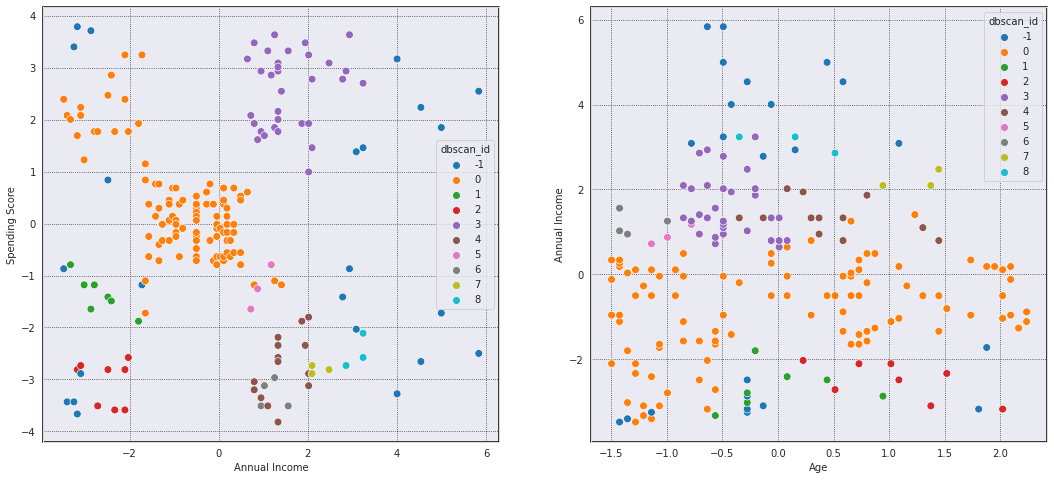

In [57]:
plt.figure(figsize = [18, 8])

plt.subplot(121)
ax1 = sns.scatterplot(data = df_num, x = 'Annual Income', y = 'Spending Score', hue = 'dbscan_id', palette = 'tab10', s = 60)
ax1.patch.set_edgecolor('black')
ax1.patch.set_linewidth(1.5)

plt.subplot(122)
ax2 = sns.scatterplot(data = df_num, x = 'Age', y = 'Annual Income', hue = 'dbscan_id', palette = 'tab10', s = 60)
ax2.patch.set_edgecolor('black')
ax2.patch.set_linewidth(1.5)

## GMM

In [58]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5, covariance_type = 'full', max_iter = 1000, random_state=21)
gmm_labels = gmm.fit_predict(df_num[cols])

In [59]:
#assign the label
df_clusters['gmm_id'] = gmm_labels
df_num['gmm_id'] = gmm_labels

df_clusters.head()

,Age,Annual Income,Spending Score,kmeans_id,hc_id,dbscan_id,gmm_id
0,19,15,39,2,0,-1,4
1,21,15,81,4,1,0,3
2,20,16,6,2,0,-1,4
3,23,16,77,4,1,0,3
4,31,17,40,2,0,1,4


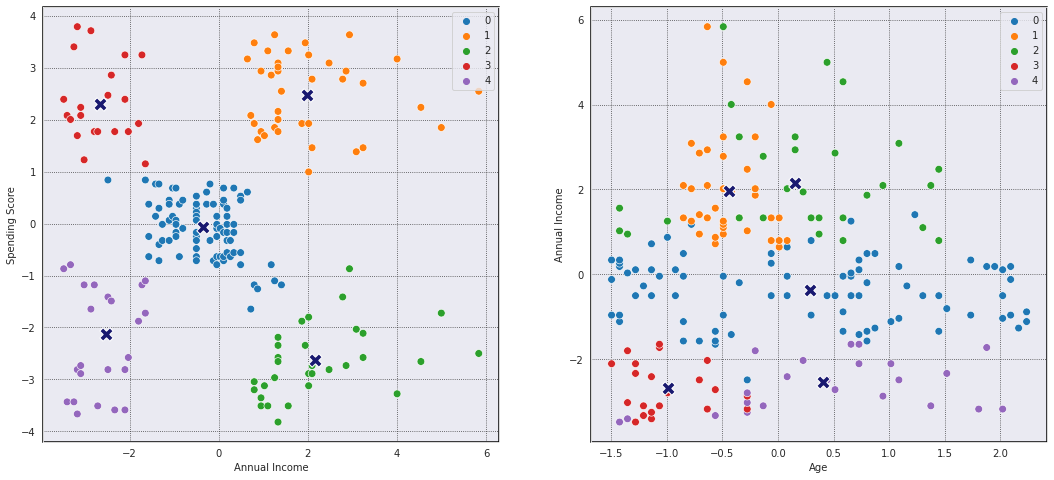

In [60]:
plt.figure(figsize = [18, 8])

plt.subplot(121)
ax1 = sns.scatterplot(data = df_num, x = 'Annual Income', y = 'Spending Score', hue = 'gmm_id', palette = 'tab10', s = 60)
sns.scatterplot(gmm.means_[:,1], gmm.means_[:,2], ax = ax1, color = 'midnightblue', marker = 'X', s = 180)
ax1.patch.set_edgecolor('black')
ax1.patch.set_linewidth(1.5)

plt.subplot(122)
ax2 = sns.scatterplot(data = df_num, x = 'Age', y = 'Annual Income', hue = 'gmm_id', palette = 'tab10', s = 60)
sns.scatterplot(gmm.means_[:,0], gmm.means_[:,1], ax = ax2, color = 'midnightblue', marker = 'X', s = 180)
ax2.patch.set_edgecolor('black')
ax2.patch.set_linewidth(1.5)

In [61]:
df_clusters['gmm_id'] = df_clusters['gmm_id'].astype('str')

In [62]:
#visualizing all three variables
fig = px.scatter_3d(df_clusters, x = 'Age', y = 'Annual Income', z = 'Spending Score',
              color='gmm_id', color_continuous_scale = 'hsv', category_orders = {'gmm_id': ['0', '1', '2', '3', '4']})
fig.update_layout(legend=dict(orientation="h"))
fig.show()